# Chunking Examples
When, where and how you can chunk ocean, with both cosima cookbook and intake catalog (currently uses xxlarge -- too much?)

TL;DR Chunk the data in the very beginning (at .search().to_dask() or cc.querying_getvar() step. For large datasets there are less/no gains to rechunking and loading after the initial importing of data. And chunk sizes should be checked at each step of computations and initial chunksizes iteratively altered to get optimal computational time. 

NB here intake is marginally slower than the cosima cookbook for exactly the same conditions, but this might differ for larger datasets 

In [1]:
import cf_xarray 

In [22]:
from dask.distributed import Client
import dask

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44063/status,
Dashboard: /proxy/44063/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46403,Workers: 7
Dashboard: /proxy/44063/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:40229,Total threads: 4
Dashboard: /proxy/35311/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:45073,


2024-08-22 17:54:09,479 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:42761 (pid=556443) exceeded 95% memory budget. Restarting...
2024-08-22 17:54:09,675 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:42761' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-db7b6a89a5d985dc6a5f139a042ac838', 90, 0, 0, 1), ('mean_chunk-aaceb070eeaa158f3fad98b203ede724', 29, 0, 1, 0, 1), ('reshape-5d65c47df3252c40b32e47198e2f7c40', 22, 0, 0, 0, 0), ('reshape-5d65c47df3252c40b32e47198e2f7c40', 39, 0, 1, 0, 1), ('reshape-5d65c47df3252c40b32e47198e2f7c40', 28, 0, 1, 0, 1), ('getitem-db7b6a89a5d985dc6a5f139a042ac838', 76, 1, 0, 0), ('mean_chunk-aaceb070eeaa158f3fad98b203ede724', 23, 0, 0, 0, 0), ('reshape-5d65c47df3252c40b32e47198e2f7c40', 23, 0, 1, 0, 1), ('getitem-db7b6a89a5d985dc6a5f139a042ac838', 89, 0, 0, 1), ('reshape-5d65c47df3252c40b32e47198e2f7c40', 32, 0, 1, 0, 0), ('mean_chunk-aaceb070eeaa158f3fad98b203ede724'

## Intake catalog:
When chunking using the intake catalog 

In [3]:
import intake

esm_datastore = intake.open_esm_datastore(
    "./qian_wthmp.json", 
    columns_with_iterables=["variable"] # This is important
)

In [4]:
%%time
ds = esm_datastore.search(variable="temp", frequency="1mon").to_dask().sel(yt_ocean = slice(-79,-70))

CPU times: user 5.04 s, sys: 1.02 s, total: 6.07 s
Wall time: 20.2 s


In [5]:
## choose chunk size here
xarray_open_kwargs = {"chunks": {'time': 100, 'st_ocean':40, 'yt_ocean':300, 'xt_ocean':1800}}

In [6]:
%%time
ds_chunked = esm_datastore.search(variable="temp", frequency="1mon")\
    .to_dask(xarray_open_kwargs = xarray_open_kwargs).sel(yt_ocean = slice(-79,-70))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 1800. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-

CPU times: user 1.66 s, sys: 98.2 ms, total: 1.75 s
Wall time: 3.44 s


We see below that the default cells as saved by the model are in very small chunks. Good chunk sizes are generally 100-200mb. https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes

In [7]:
ds.temp

<xarray.DataArray 'temp' (time: 600, st_ocean: 75, yt_ocean: 213, xt_ocean: 3600)> Size: 138GB
dask.array<getitem, shape=(600, 75, 213, 3600), dtype=float32, chunksize=(1, 7, 213, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 2kB -79.0 -78.95 -78.91 ... -70.08 -70.04
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

In [8]:
ds_chunked.temp

<xarray.DataArray 'temp' (time: 600, st_ocean: 75, yt_ocean: 213, xt_ocean: 3600)> Size: 138GB
dask.array<getitem, shape=(600, 75, 213, 3600), dtype=float32, chunksize=(3, 40, 213, 1800), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 2kB -79.0 -78.95 -78.91 ... -70.08 -70.04
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

Let's compute the mean temperature in the Southern ocean. The cells below show that chunking in advance from intake catalog improves compute time.

In [9]:
%%time
ds_mean = ds.cf.mean(dim = ('longitude', 'latitude')).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 16.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3min 47s, sys: 14.1 s, total: 4min 1s
Wall time: 4min 54s


In [10]:
%%time
ds_mean_chunked = ds_chunked.cf.mean(dim = ('longitude', 'latitude')).compute()

CPU times: user 34.7 s, sys: 3.74 s, total: 38.5 s
Wall time: 2min 30s


If taking a spatial mean, it is more useful to group the temperature field in larger chunks in time to make use of the CPU time (model output is saved in single time steps). However, the chunked field has to be loaded into dask to make full use of this, and the amount of data might not always make this possible. For example, this subset of data is not able to be loaded and computed using the method below:
```
ds_time_chunked = ds_chunked.chunk({'time':100}).load()
ds_mean_time_chunked_load = ds_time_chunked.cf.mean(dim = ('longitude', 'latitude')).compute()
```

Note that using the ARE xxlarge notebook, the memory stored for each worker is not optimal, even after chunking (see screenshot below). This is due to the small chunks in time and amending would require rechunking and saving a netcdf file of the full field, which is not always possible (>100GB in this example).
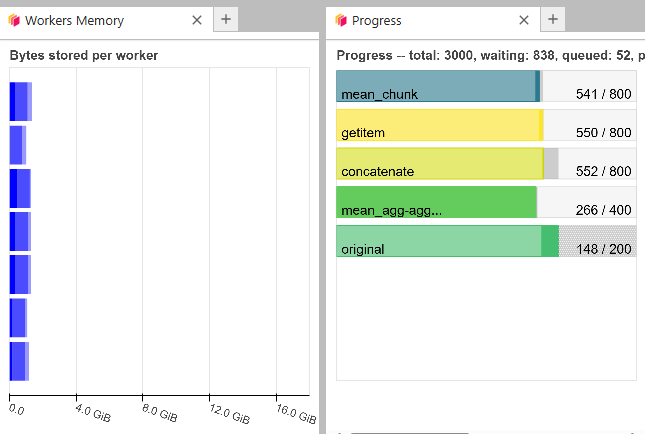

## Cosima Cookbook

In [14]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr


In [15]:
session=cc.database.create_session()
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'

In [16]:
%%time
temp_cc = cc.querying.getvar(expt=exp_wthmp, variable='temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'})\
                        .sel(yt_ocean = slice(-79,-70))#.isel(st_ocean = 0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

CPU times: user 4.01 s, sys: 518 ms, total: 4.53 s
Wall time: 14.5 s


In [17]:
%%time
temp_cc_chunked = cc.querying.getvar(expt=exp_wthmp, variable='temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'}, 
                        chunks = {'time': 100, 'st_ocean':40, 'yt_ocean':300, 'xt_ocean':1800})\
                        .sel(yt_ocean = slice(-79,-70))#.isel(st_ocean = 0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 1800. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-

CPU times: user 2.49 s, sys: 302 ms, total: 2.79 s
Wall time: 4.31 s


In [18]:
temp_cc_chunked

<xarray.DataArray 'temp' (time: 600, st_ocean: 75, yt_ocean: 213, xt_ocean: 3600)> Size: 138GB
dask.array<getitem, shape=(600, 75, 213, 3600), dtype=float32, chunksize=(3, 40, 213, 1800), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 2kB -79.0 -78.95 -78.91 ... -70.08 -70.04
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

Again chunking in advance reduces compute time.

In [19]:
%%time
cc_mean = temp_cc.cf.mean(dim = ('longitude', 'latitude')).compute()

CPU times: user 3min 50s, sys: 16 s, total: 4min 6s
Wall time: 4min 19s


In [20]:
%%time
cc_mean_chunked = temp_cc_chunked.cf.mean(dim = ('longitude', 'latitude')).compute()

CPU times: user 37.8 s, sys: 4.61 s, total: 42.4 s
Wall time: 2min 30s


Again, chunking in time and loading to compute more quickly does not work at this scale (array is too big for the avaliable memory). 
Therefore:
1. Rechunking large datasets after variables are open in the jupyter notebook should be avoided, as they need to be loaded in to dask for the chunking to take effect. This does not usually work with large datasets, but could be advantageous for smaller datasets. 
2. The chunking should err on the smaller side, should more complex calculations require more memory. See example of computationally intensive calculation below. 

For an example of a more computationally intensive calculation, let's say we wanted to compute the numerical mean of the temperature anomaly (from a climatology). We compute theses for the chunked and not chunked datasets:

In [25]:
climatology_chunked = temp_cc_chunked.coarsen(time = 12).construct(time=('year', 'month')).mean('year')
anomaly_chunked = temp_cc_chunked.coarsen(time=12).construct(time=('year', 'month')) - climatology_chunked
anomaly_chunked

<xarray.DataArray 'temp' (year: 50, month: 12, st_ocean: 75, yt_ocean: 213,
                          xt_ocean: 3600)> Size: 138GB
dask.array<sub, shape=(50, 12, 75, 213, 3600), dtype=float32, chunksize=(1, 12, 40, 213, 1800), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 2kB -79.0 -78.95 -78.91 ... -70.08 -70.04
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      (year, month) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:...
Dimensions without coordinates: year, month

In [26]:
climatology = temp_cc.coarsen(time = 12).construct(time=('year', 'month')).mean('year')
anomaly = temp_cc.coarsen(time=12).construct(time=('year', 'month')) - climatology
anomaly

<xarray.DataArray 'temp' (year: 50, month: 12, st_ocean: 75, yt_ocean: 213,
                          xt_ocean: 3600)> Size: 138GB
dask.array<sub, shape=(50, 12, 75, 213, 3600), dtype=float32, chunksize=(1, 12, 7, 213, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 2kB -79.0 -78.95 -78.91 ... -70.08 -70.04
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      (year, month) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:...
Dimensions without coordinates: year, month

In [32]:
%%time
anomaly_mean = anomaly.cf.mean(dim = ('longitude', 'latitude', 'vertical')).compute()

Task exception was never retrieved
future: <Task finished name='Task-1592128' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1592130' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retriev

CPU times: user 3min 54s, sys: 24.8 s, total: 4min 19s
Wall time: 5min 33s


In [33]:
%%time
## this however fails
anomaly_chunked_mean = anomaly_chunked.cf.mean(dim = ('longitude', 'latitude', 'vertical')).compute()

2024-08-22 17:52:46,560 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 15.13 GiB -- Worker memory limit: 18.00 GiB
2024-08-22 17:52:47,038 - distributed.worker.memory - WARNING - Worker is at 68% memory usage. Resuming worker. Process memory: 12.41 GiB -- Worker memory limit: 18.00 GiB
2024-08-22 17:53:43,919 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 15.15 GiB -- Worker memory limit: 18.00 GiB
2024-08-22 17:53:45,046 - distributed.worker.memory - WARNING - Worker is at 70% memory usage. Resuming worker. Process memory: 12.77 GiB -- Worker memory limit: 18.00 GiB
2024-08-22 17:53:51,426 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 14.77 GiB -- Worker memory limit: 18.00 GiB
2024-08-22 17:53:52,819 - distributed.worker.memory - WARNING - Worker is at 66% memory usage. Resuming worker. Process memory: 11.97 GiB --

KeyboardInterrupt: 

2024-08-22 17:54:35,832 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-08-22 17:54:36,585 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-08-22 17:54:36,588 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name='gather_dep(tcp://127.0.0.1:40229, {...})' coro=<Worker.gather_dep() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-08-22 17:54:36,588 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('concatenate-open_dataset-temp-getitem-db7b6a89a5d985dc6a5f139a042ac838', 101, 1, 0, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-08-22 17:54:3

As seen for the anomaly_chunked dataset above, although the initial temp_cc_chunked dataset had chunks of size <200MB, the anomaly_chunked dataset ended up with larger chunks >700mb. In this case, smaller chunks would have had to be chosen in the very beginning, as rechunking and loading >100gb of data would not have been feasible. 
i.e. ```anomaly_chunked.chunk({'xt_ocean':600})``` would not have loaded either.

This is an example where larger initial chunk sizes might not be beneficial, and the unchunked dataset actually filled the dask worker memory without crashing. Through trial and error picking initial chunk size and looking at the chunksizes at each step, an optimal apprach can be chosen.

In [4]:

lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

In [5]:
ht = cc.querying.getvar(exp_wthmp, 'ht', session, n=1).drop(['geolat_t', 'geolon_t']).sel(yt_ocean=lat_lim).load() #.drop(['geolat_c', 'geolon_c'])
hu = cc.querying.getvar(exp_wthmp, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).sel(yu_ocean=lat_lim).load() #.drop(['geolat_c', 'geolon_c'])

In [18]:
u_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00').sel(yu_ocean = lat_lim).isel(st_ocean = 0)
v_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='v', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00').sel(yu_ocean = lat_lim).isel(st_ocean = 0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [8]:
#get access grid to integrate

In [13]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [14]:
# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [15]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [16]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [19]:
vel = xr.merge([coordinates, u_wthmp, v_wthmp, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [20]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [21]:
grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [22]:
# creating mask to highlight slope and shelf processes, looking only at regions shallower than 2000m
cluster_mask_access = xr.where(hu < 1000, True, False)

In [23]:
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)
circ_ASC_area = (area_u*cluster_mask_access).sum()                                                                                                                                                                                        

Now we want to calculate a time series for circumpolarly averaged surface speed. With the masking and without any chunking we do so as follows

In [18]:
speed_wthmp = np.sqrt(u_wthmp**2 + v_wthmp**2).where(cluster_mask_access == True)
speed_wthmp_timeseries = grid.integrate(speed_wthmp, ['X','Y'])

However, when the intermediate step before printing is looked at, the chunks are very small (<1MB) and there are many tasks, which will result in longer compute time. If you run ```speed_wthmp_timeseries.load()``` it will likely crash

In [19]:
speed_wthmp

<xarray.DataArray (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
dask.array<where, shape=(600, 440, 3600), dtype=float32, chunksize=(1, 250, 400), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

Now let's try to rechunk u_wthmp and v_wthmp, 100MB to <1GB is a good rule of thumb. 

In [20]:
u_wthmp_chunk = u_wthmp.chunk({'time':100,'xu_ocean':1200,'yu_ocean': 250})
v_wthmp_chunk = v_wthmp.chunk({'time':100,'xu_ocean':1200,'yu_ocean': 250})
v_wthmp_chunk

<xarray.DataArray 'v' (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
dask.array<rechunk-merge, shape=(600, 440, 3600), dtype=float32, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Attributes:
    long_name:      j-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_y_velocity
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [21]:
speed_wthmp_chunk = np.sqrt(u_wthmp_chunk**2 + v_wthmp_chunk**2).where(cluster_mask_access == True)
speed_wthmp_chunk_timeseries = grid.integrate(speed_wthmp_chunk, ['X','Y'])
speed_wthmp_chunk # many fewer graph layers this time

<xarray.DataArray (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
dask.array<where, shape=(600, 440, 3600), dtype=float32, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

Crucially, if the chunking is not computed on dask before being used in your calculation, when `u_wthmp_chunk` is called, the rechunking is computed each time, resulting in a slower calculation. Running ```speed_wthmp_chunk_timeseries.load()``` will likely fail too. We can check a subset of data to see this happening.

In [24]:
%%time
## choosing only 10 years of CHUNKED data
n = 1
speed_wthmp = np.sqrt(u_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2 + v_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2).where(cluster_mask_access == True)
speed_wthmp_chunk_t = (grid.integrate(speed_wthmp, ['X','Y']).load()/circ_ASC_area)


CPU times: user 19.5 s, sys: 1.27 s, total: 20.8 s
Wall time: 2min 11s


In [26]:
%%time
## choosing only 10 years of unchunked data, wall time is slower than that of chunked data!

speed_wthmp = np.sqrt(u_wthmp.isel(time = slice(120*n, 120*(n+1)))**2 + v_wthmp.isel(time = slice(120*n, 120*(n+1)))**2).where(cluster_mask_access == True)
speed_wthmp_coast_t = grid.integrate(speed_wthmp, ['X','Y']).load()/circ_ASC_area

CPU times: user 28 s, sys: 1.07 s, total: 29 s
Wall time: 1min 16s


Therefore, we load the chunked data. On the intake catalog, if the chunking kwargs are added in the beginning, the data should already be loaded and this step would not be neccessary. 

In [41]:
%%time
u_wthmp_chunk.load(), v_wthmp_chunk.load()

(<xarray.DataArray 'u' (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
 array([[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.03613812,  0.03168876,  0.02869883, ...,  0.048242  ,
           0.04387836,  0.04004395],
         [ 0.03526715,  0.03102086,  0.02941158, ...,  0.04694905,
           0.0435827 ,  0.03973115],
         [ 0.03503266,  0.03239677,  0.03183516, ...,  0.04314907,
           0.04152586,  0.03884263]],
 
        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
       

In [28]:
%%time
## this is now a lot faster to load for 10 years of data
speed_wthmp = np.sqrt(u_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2 + v_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2).where(cluster_mask_access == True)
speed_wthmp_chunk_t= grid.integrate(speed_wthmp, ['X','Y']).load()/circ_ASC_area


CPU times: user 26.2 s, sys: 1.47 s, total: 27.7 s
Wall time: 1min 49s


In [29]:
speed_wthmp_chunk = np.sqrt(u_wthmp_chunk**2 + v_wthmp_chunk**2).where(cluster_mask_access == True)
speed_wthmp_chunk_timeseries = grid.integrate(speed_wthmp_chunk, ['X','Y'])

In [30]:
%%time
## now it is possible to compute the whole timeseries in one go. 
speed_wthmp_chunk_timeseries.load()

2024-08-16 12:06:08,630 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.73 GiB -- Worker memory limit: 4.50 GiB
2024-08-16 12:06:50,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.50 GiB
2024-08-16 12:06:54,105 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.63 GiB -- Worker memory limit: 4.50 GiB
2024-08-16 12:06:54,117 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memo

CPU times: user 1min 32s, sys: 5.68 s, total: 1min 37s
Wall time: 7min 16s


<xarray.DataArray (time: 600)> Size: 2kB
array([2.4590647e+11, 3.4526809e+11, 3.6069864e+11, 3.7339057e+11,
       3.4208281e+11, 2.5507666e+11, 2.7241053e+11, 2.2662226e+11,
       1.7503368e+11, 1.7190771e+11, 1.9223613e+11, 2.1878024e+11,
       2.4658004e+11, 3.4547696e+11, 3.6246186e+11, 3.7434029e+11,
       3.4252813e+11, 2.5478544e+11, 2.7292264e+11, 2.2635758e+11,
       1.7531640e+11, 1.7323157e+11, 1.9426850e+11, 2.2103355e+11,
       2.4894318e+11, 3.4805855e+11, 3.6583109e+11, 3.7591699e+11,
       3.4597929e+11, 2.5808067e+11, 2.7552950e+11, 2.2898216e+11,
       1.7697181e+11, 1.7465503e+11, 1.9583825e+11, 2.2299987e+11,
       2.5058468e+11, 3.5019309e+11, 3.6764988e+11, 3.7618726e+11,
       3.4602362e+11, 2.5863073e+11, 2.7605005e+11, 2.3038385e+11,
       1.7732654e+11, 1.7459085e+11, 1.9585548e+11, 2.2352088e+11,
       2.5236023e+11, 3.5239405e+11, 3.7054546e+11, 3.8052590e+11,
       3.5010311e+11, 2.6160765e+11, 2.7767993e+11, 2.3220955e+11,
       1.7885841e+11, 1.7672466e+11, 1.9789326e+11, 2.2567400e+11,
       2.5389724e+11, 3.5458961e+11, 3.7131341e+11, 3.8059655e+11,
       3.5071594e+11, 2.6164414e+11, 2.7979579e+11, 2.3330338e+11,
       1.7950356e+11, 1.7790286e+11, 1.9982968e+11, 2.2663987e+11,
       2.5440536e+11, 3.5537374e+11, 3.7323558e+11, 3.8191710e+11,
       3.5430089e+11, 2.6464141e+11, 2.8194501e+11, 2.3593704e+11,
...
       2.4812614e+11, 2.4611062e+11, 2.8404390e+11, 3.0847048e+11,
       3.3876620e+11, 4.3265062e+11, 4.4894149e+11, 4.6023718e+11,
       4.4570601e+11, 3.4793675e+11, 3.6391040e+11, 3.1227789e+11,
       2.4806272e+11, 2.4649225e+11, 2.8407067e+11, 3.0705982e+11,
       3.3639052e+11, 4.3679665e+11, 4.5356791e+11, 4.6505076e+11,
       4.4870871e+11, 3.4879694e+11, 3.6524563e+11, 3.1535802e+11,
       2.5052463e+11, 2.4812906e+11, 2.8722722e+11, 3.1118600e+11,
       3.3909676e+11, 4.3422102e+11, 4.5447879e+11, 4.6604016e+11,
       4.4958564e+11, 3.5155775e+11, 3.6702270e+11, 3.1681996e+11,
       2.5219793e+11, 2.4902176e+11, 2.8898460e+11, 3.1184005e+11,
       3.4051467e+11, 4.3547578e+11, 4.5276375e+11, 4.6904502e+11,
       4.4948816e+11, 3.5298293e+11, 3.6938872e+11, 3.1821644e+11,
       2.5415121e+11, 2.5106088e+11, 2.9101140e+11, 3.1401961e+11,
       3.4220396e+11, 4.4045913e+11, 4.5867195e+11, 4.6804592e+11,
       4.5246903e+11, 3.5604277e+11, 3.7309855e+11, 3.2297914e+11,
       2.5596900e+11, 2.5400430e+11, 2.9372888e+11, 3.1619953e+11,
       3.4393358e+11, 4.3947626e+11, 4.5732620e+11, 4.7106956e+11,
       4.5372437e+11, 3.5890613e+11, 3.7621789e+11, 3.2650491e+11,
       2.5932895e+11, 2.5723879e+11, 2.9957335e+11, 3.2091347e+11],
      dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


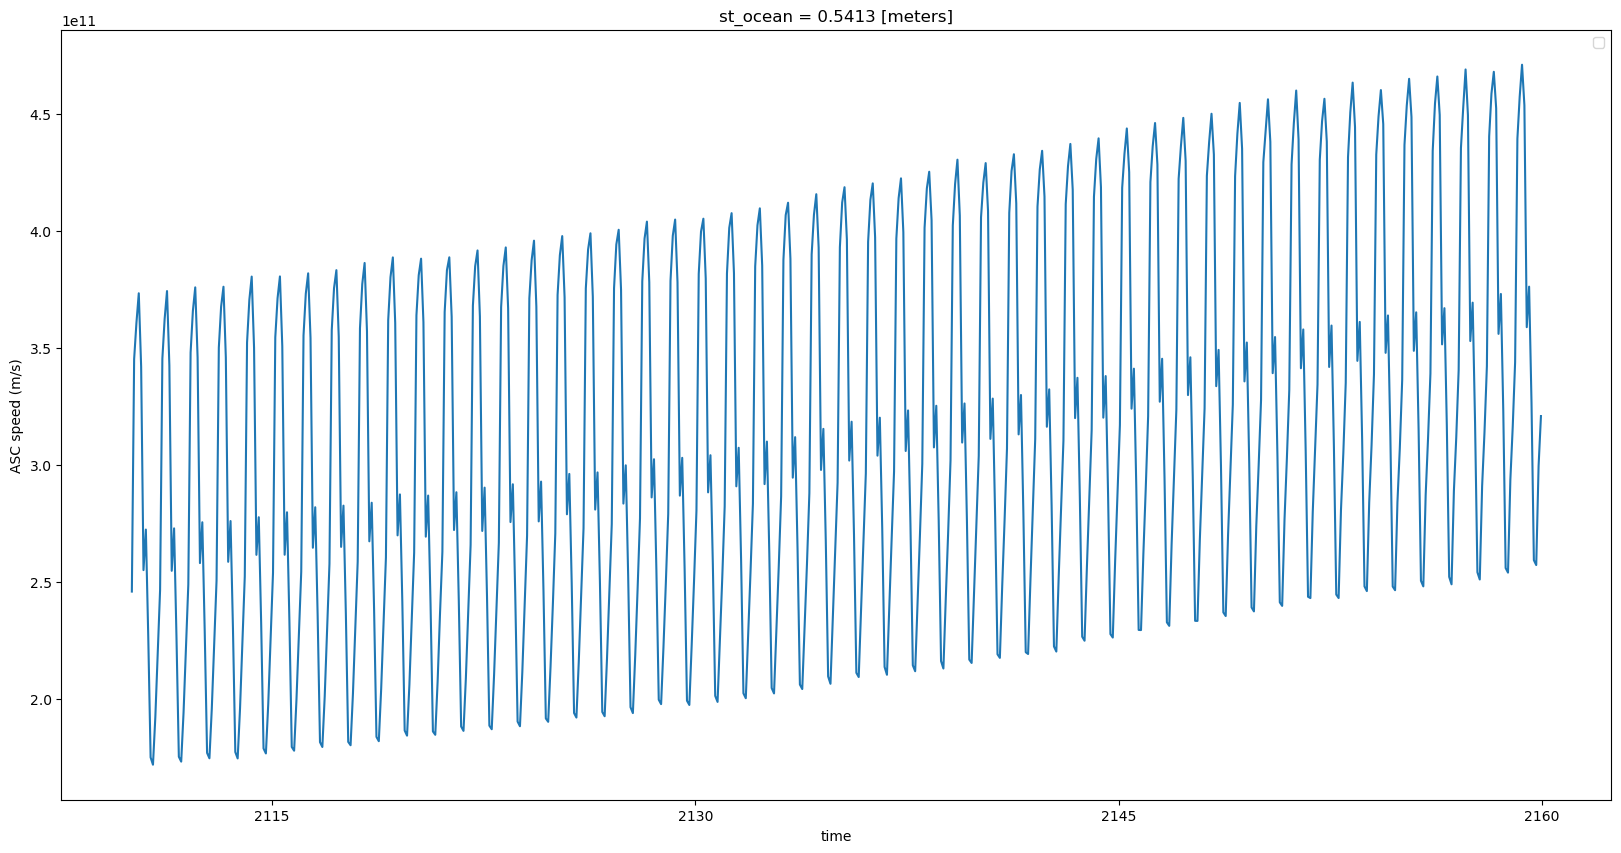

In [47]:
# Done!
plt.figure(figsize = (20,10))
speed_wthmp_chunk_timeseries.plot()
plt.ylabel('ASC speed (m/s)')
plt.legend()

In [ ]:
%%time
## if using larger chunks from the beginning
u_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00', chunks = {'time':100,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim).isel(st_ocean = 0)
v_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='v', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00', chunks = {'time':100,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim).isel(st_ocean = 0)


In [ ]:
%%time
speed_wthmp_chunkinit = np.sqrt(u_wthmp**2 + v_wthmp**2).where(cluster_mask_access == True)
speed_wthmp_chunkinit_timeseries = grid.integrate(speed_wthmp_chunkinit, ['X','Y']).load()